In [1]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSim
from DefaultParams import *


print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Params for multi-trial sims
numtrials=30
dtRate=250

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
rBal =  5.823529411764702 15.882352941176466 Hz


In [2]:
# This code cell creates connectivity, stimulus, and runs sims

import warnings


    
# Get connectivity matrix
J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)
Jx=sigmastim*(np.random.randn(N,StimDim)+1.0)

maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,dtRate)
re = np.zeros((numtrials,Ne,len(RateTime)))
ri = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for iii in range(numtrials):        
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        re[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        ri[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print('Sim for trial',iii,'of',numtrials,'complete after',tm()-t0,'s')        
tSim=tm()-t0
print('Time for all sims:',tSim,'s')


MeanERates=re.mean()
MeanIRates=ri.mean()

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


Sim for trial 0 of 10 complete after 18.17723798751831 s
Sim for trial 1 of 10 complete after 36.28354096412659 s
Sim for trial 2 of 10 complete after 54.341228008270264 s
Sim for trial 3 of 10 complete after 72.42126989364624 s
Sim for trial 4 of 10 complete after 90.60846614837646 s
Sim for trial 5 of 10 complete after 108.72437596321106 s
Sim for trial 6 of 10 complete after 126.80554008483887 s
Sim for trial 7 of 10 complete after 144.86720299720764 s
Sim for trial 8 of 10 complete after 162.94149899482727 s
Sim for trial 9 of 10 complete after 181.01194095611572 s
Time for all sims: 181.01212000846863 s
rSim = 5.1755799999999965 14.174350000000004 Hz


2327 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Mean EE corr: 0.011925357397704308
Std EE corr: 0.35765728035143723
Mean connected EE corr: 0.019292635332667157
Mean unconnected EE corr: 0.011102342695413957


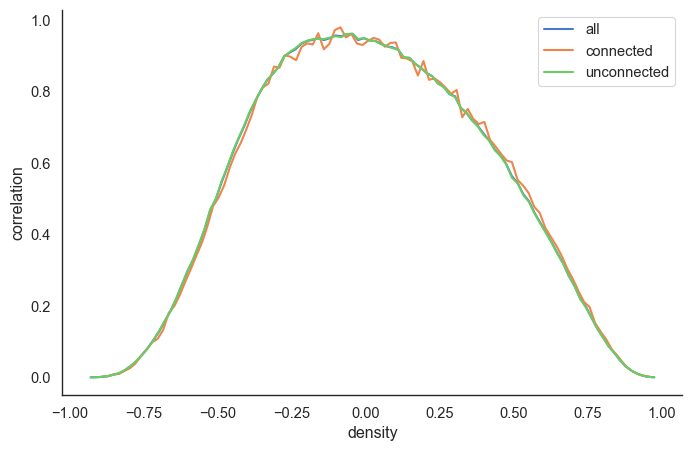

In [3]:
import seaborn as sns

sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

rmin=1.0/1000

# Counts from rates with burn-in and losing last bins bc of noise stuff
ECounts = dtRate*re[:,:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]

# Average over trials
ECounts = ECounts.mean(axis=0)

ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
print(len(ECutoffInds),'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]


Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]

print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())

print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())



hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

plt.figure(figsize=(8,5))
plt.plot(bAllEE[1:],hAllEE, label='all')
plt.plot(bConnEE[1:],hConnEE, label='connected')
plt.plot(bUnconnEE[1:],hUnconnEE, label='unconnected')
plt.xlabel('density')
plt.ylabel('correlation')
plt.legend(loc='best')
sns.despine()
